Image Features
==============

In [1]:
from multiprocessing import Pool, cpu_count
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import fbeta_score
from PIL import Image, ImageStat
from skimage import io
import xgboost as xgb
import pandas as pd
import numpy as np
import glob, cv2
import random
import scipy

random.seed(1)
np.random.seed(1)
np.seterr(divide='ignore', invalid='ignore')

def get_features(path):
    try:
        st = []
        #pillow jpg
        img = Image.open(path)
        im_stats_ = ImageStat.Stat(img)
        st += im_stats_.sum
        st += im_stats_.mean
        st += im_stats_.rms
        st += im_stats_.var
        st += im_stats_.stddev
        img = np.array(img)[:,:,:3]
        st += [scipy.stats.kurtosis(img[:,:,0].ravel())]
        st += [scipy.stats.kurtosis(img[:,:,1].ravel())]
        st += [scipy.stats.kurtosis(img[:,:,2].ravel())]
        st += [scipy.stats.skew(img[:,:,0].ravel())]
        st += [scipy.stats.skew(img[:,:,1].ravel())]
        st += [scipy.stats.skew(img[:,:,2].ravel())]
        #cv2 jpg
        img = cv2.imread(path)
        ## Generate no of rectangles
        
        bw = cv2.imread(path,0)
        st += list(cv2.calcHist([bw],[0],None,[256],[0,256]).flatten()) #bw 
        st += list(cv2.calcHist([img],[0],None,[256],[0,256]).flatten()) #r
        st += list(cv2.calcHist([img],[1],None,[256],[0,256]).flatten()) #g
        st += list(cv2.calcHist([img],[2],None,[256],[0,256]).flatten()) #b
        try:
            #skimage tif
            imgr = io.imread(path.replace('jpg','tif'))
            tf = imgr[:, :, 3]
            st += list(cv2.calcHist([tf],[0],None,[256],[0,65536]).flatten()) #near ifrared
            ndvi = ((imgr[:, :, 3] - imgr[:, :, 0]) / (imgr[:, :, 3] + imgr[:, :, 0])) #water ~ -1.0, barren area ~ 0.0, shrub/grass ~ 0.2-0.4, forest ~ 1.0
            st += list(np.histogram(ndvi,bins=20, range=(-1,1))[0])
            ndvi = ((imgr[:, :, 3] - imgr[:, :, 1]) / (imgr[:, :, 3] + imgr[:, :, 1]))
            st += list(np.histogram(ndvi,bins=20, range=(-1,1))[0])
            ndvi = ((imgr[:, :, 3] - imgr[:, :, 2]) / (imgr[:, :, 3] + imgr[:, :, 2]))
            st += list(np.histogram(ndvi,bins=20, range=(-1,1))[0])
        except:
            st += [-1 for i in range(256)]
            st += [-2 for i in range(60)]
            print('err', path.replace('jpg','tif'))
        m, s = cv2.meanStdDev(img) #mean and standard deviation
        st += list(m)
        st += list(s)
        st += [cv2.Laplacian(bw, cv2.CV_64F).var()] 
        st += [cv2.Laplacian(img, cv2.CV_64F).var()]
        st += [cv2.Sobel(bw,cv2.CV_64F,1,0,ksize=5).var()]
        st += [cv2.Sobel(bw,cv2.CV_64F,0,1,ksize=5).var()]
        st += [cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5).var()]
        st += [cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5).var()]
        st += [(bw<30).sum()]
        st += [(bw>225).sum()]
    except:
        print(path)
    return [path, st]

def normalize_img(paths):
    imf_d = {}
    p = Pool(cpu_count())
    ret = p.map(get_features, paths)
    for i in range(len(ret)):
        imf_d[ret[i][0]] = ret[i][1]
    ret = []
    fdata = [imf_d[f] for f in paths]
    return fdata

in_path = '../input/'
train = pd.read_csv(in_path + 'train.csv')[:500]
train['path'] = train['image_name'].map(lambda x: in_path + 'train-jpg/' + x + '.jpg')
y = train['tags'].str.get_dummies(sep=' ')
xtrain = normalize_img(train['path']); print('train...')

test_jpg = glob.glob(in_path + 'test-jpg/*')[:500]
test = pd.DataFrame([[p.split('/')[3].replace('.jpg',''),p] for p in test_jpg])
test.columns = ['image_name','path']
xtest = normalize_img(test['path']); print('test...')

train...
test...


Model 1
=======

In [2]:
etr = ExtraTreesRegressor(n_estimators=200, max_depth=30, n_jobs=-1, random_state=1)
etr.fit(xtrain, y); print('etr fit...')

train_pred = etr.predict(xtrain)
train_pred[train_pred > 0.20] = 1
train_pred[train_pred < 1] = 0
print(fbeta_score(y,train_pred,beta=2, average='samples'))

pred1 = etr.predict(xtest); print('etr predict...')
etr_test = pd.DataFrame(pred1, columns=y.columns)
etr_test['image_name'] =  test[['image_name']]

tags = []
for r in etr_test[y.columns].values:
    r = list(r)
    tags.append(' '.join([j[1] for j in sorted([[r[i],y.columns[i]] for i in range(len(y.columns)) if r[i]>.23], reverse=True)]))

test['tags'] = tags
test[['image_name','tags']].to_csv('submission_blend.csv', index=False)
test.head()

etr fit...
1.0
etr predict...


image_name                              path                         tags
0  test_25872  ../input/test-jpg/test_25872.jpg                       cloudy
1   test_2428   ../input/test-jpg/test_2428.jpg                       cloudy
2  test_18499  ../input/test-jpg/test_18499.jpg                primary clear
3  test_16290  ../input/test-jpg/test_16290.jpg  primary partly_cloudy clear
4   test_3576   ../input/test-jpg/test_3576.jpg         cloudy primary water

Model 2
=======

In [3]:
xgb_train = pd.DataFrame(train[['path']], columns=['path'])
xgb_test = pd.DataFrame(test[['image_name']], columns=['image_name'])
print('xgb fit...')
for c in y.columns:
    model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.3, max_depth=4, seed=1, base_score=0.5)
    model.fit(np.array(xtrain), y[c])
    xgb_train[c] = model.predict_proba(np.array(xtrain))[:, 1]
    xgb_test[c] = model.predict_proba(np.array(xtest))[:, 1]
    print(c)

train_pred = xgb_train[y.columns].values
train_pred[train_pred >0.20] = 1
train_pred[train_pred < 1] = 0
print(fbeta_score(y,train_pred,beta=2, average='samples')) 
print('xgb predict...')

xgb fit...
agriculture
artisinal_mine
bare_ground
blooming
blow_down
clear
cloudy
conventional_mine
cultivation
habitation
haze
partly_cloudy
primary
road
selective_logging
slash_burn
water
0.998857142857
xgb predict...


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1119: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


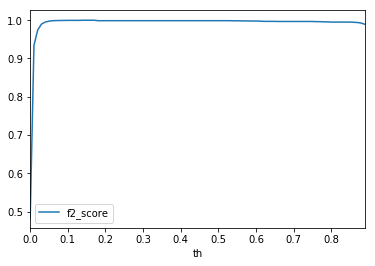

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

th = []
train_predx = xgb_train[y.columns].values
for i in np.arange(0.0, 0.9, 0.01):
    train_pred = train_predx.copy()
    train_pred[train_pred >i] = 1
    train_pred[train_pred < 1] = 0
    th.append([i, fbeta_score(y,train_pred,beta=2, average='samples')])
_ = pd.DataFrame(th, columns=['th','f2_score']).plot(kind='line', x='th', y='f2_score')

Blend
=====

In [5]:
xgb_test.columns = [x+'_' if x not in ['image_name'] else x for x in xgb_test.columns]
blend = pd.merge(etr_test, xgb_test, how='left', on='image_name')

for c in y.columns:
    blend[c] = (blend[c] * 0.60)  + (blend[c+'_'] * 0.40)

blend = blend[etr_test.columns]

Prepare Submission
==================

In [6]:
tags = []
for r in blend[y.columns].values:
    r = list(r)
    tags.append(' '.join([j[1] for j in sorted([[r[i],y.columns[i]] for i in range(len(y.columns)) if r[i]>.20], reverse=True)]))

test['tags'] = tags
test[['image_name','tags']].to_csv('submission_blend.csv', index=False)
test.head()

image_name                              path  \
0  test_25872  ../input/test-jpg/test_25872.jpg   
1   test_2428   ../input/test-jpg/test_2428.jpg   
2  test_18499  ../input/test-jpg/test_18499.jpg   
3  test_16290  ../input/test-jpg/test_16290.jpg   
4   test_3576   ../input/test-jpg/test_3576.jpg   

                                tags  
0                             cloudy  
1                             cloudy  
2                      primary clear  
3  primary clear partly_cloudy water  
4               cloudy water primary

Visualize Results
=================

artisinal_mine
bare_ground
blooming
blow_down
conventional_mine
selective_logging
slash_burn


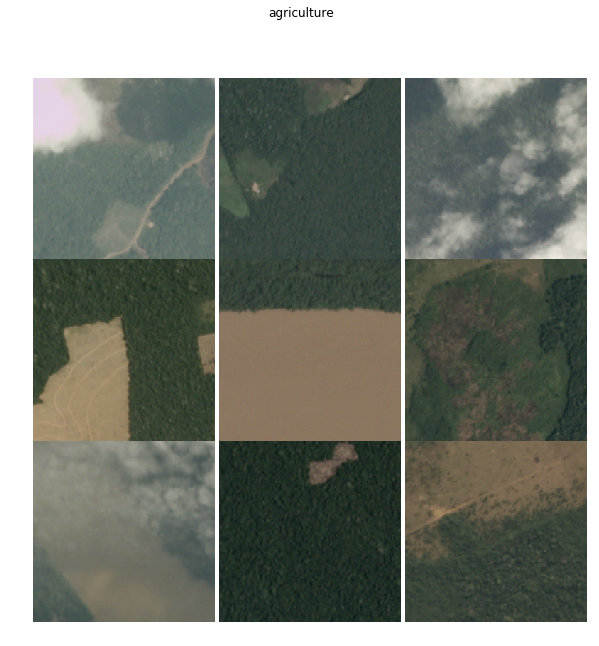

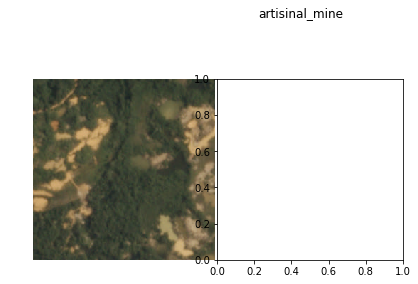

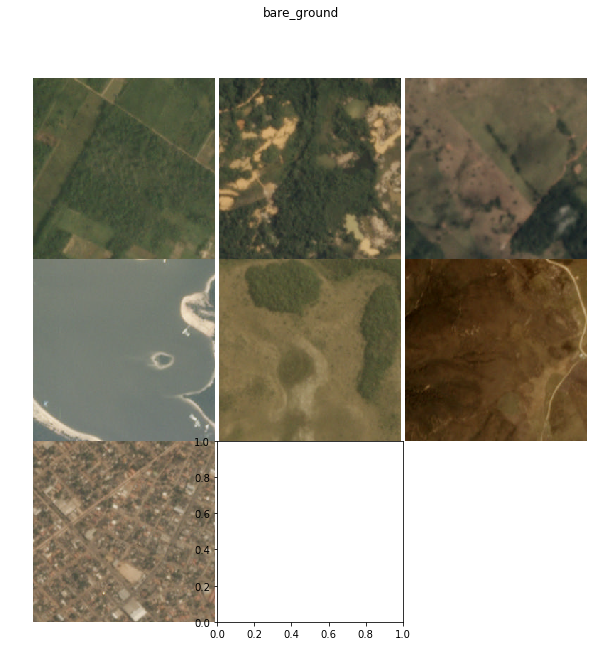

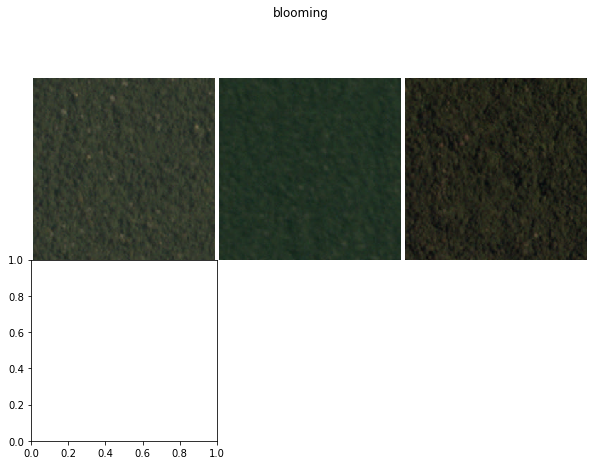

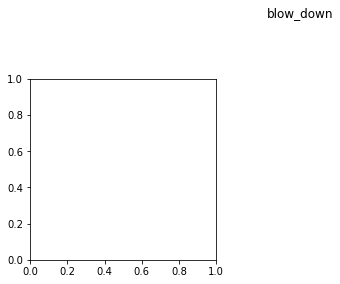

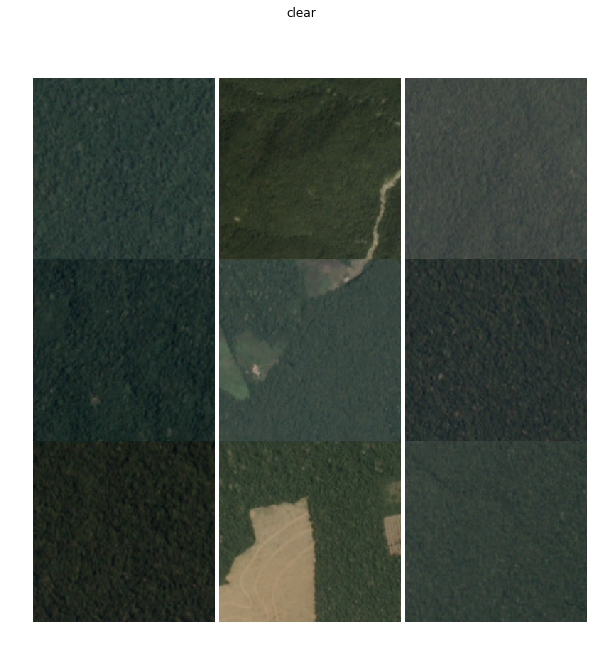

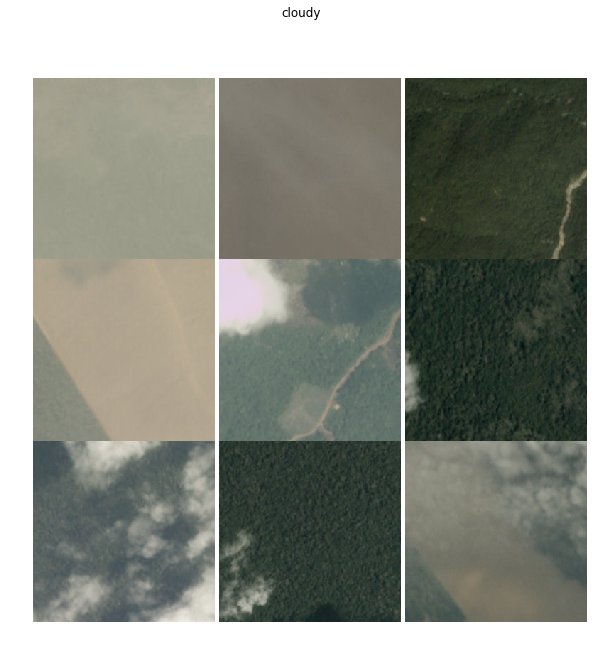

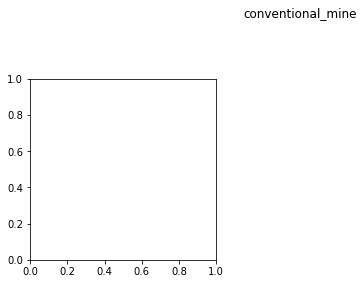

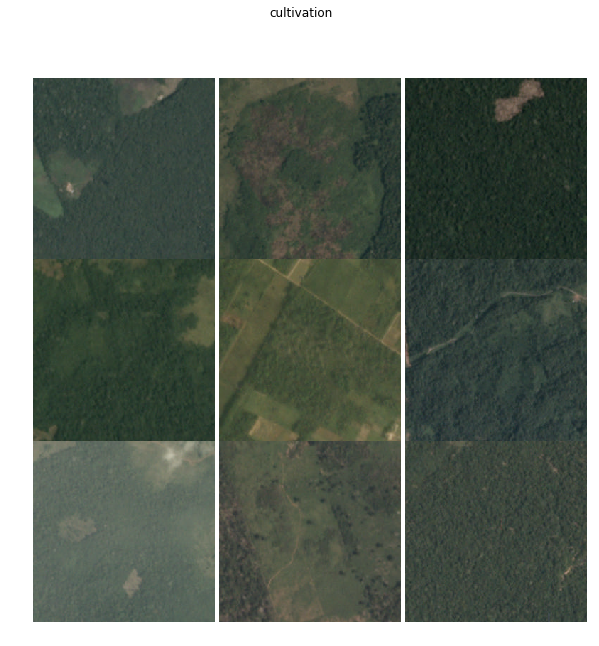

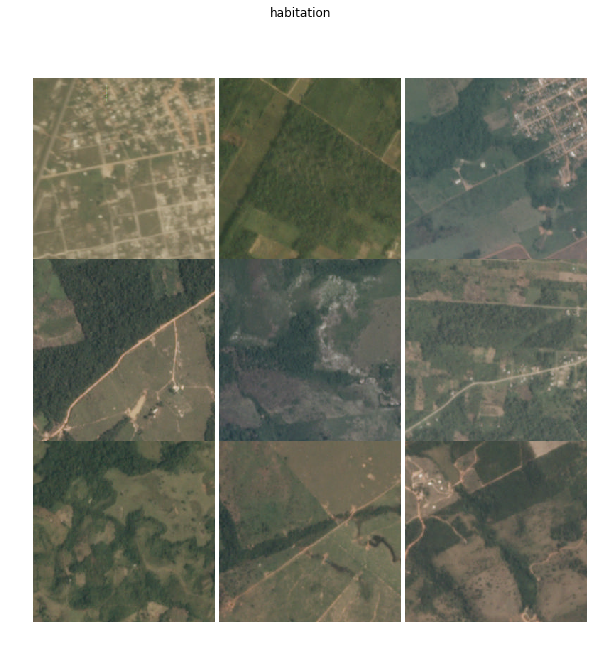

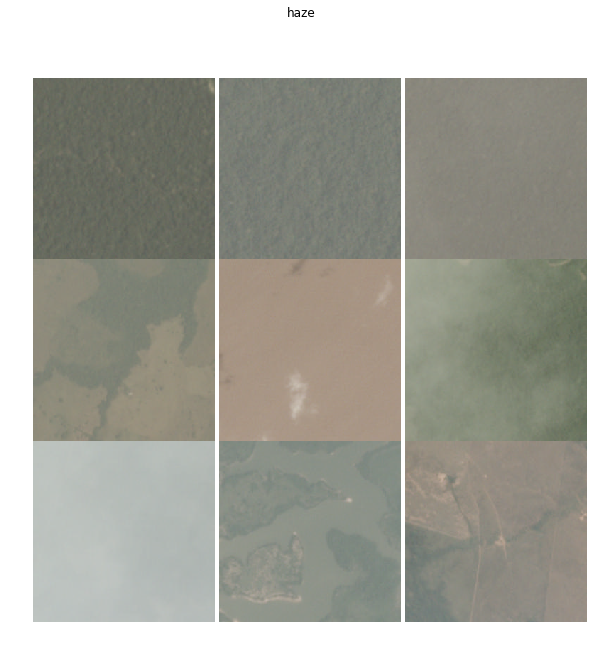

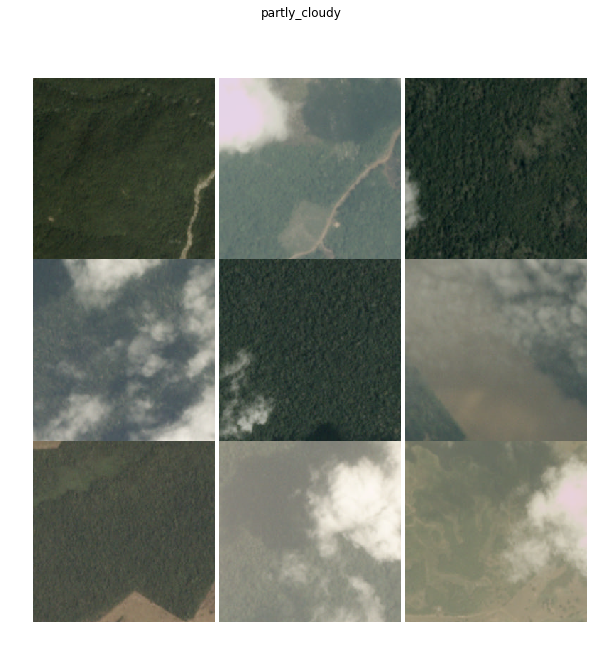

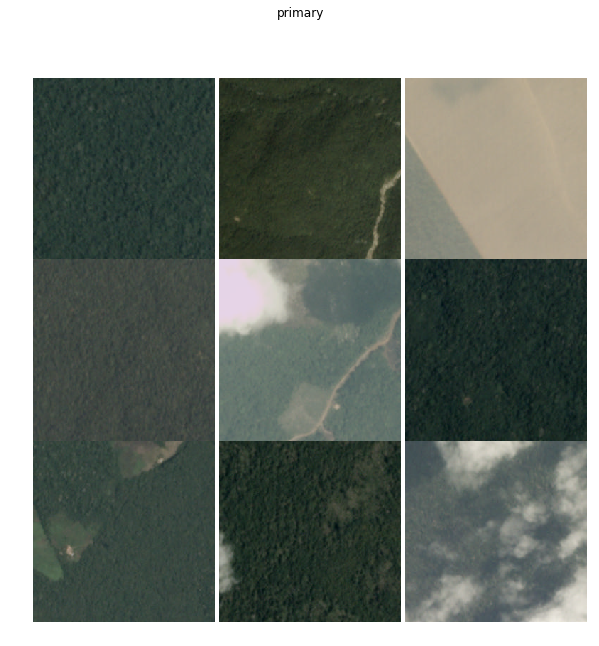

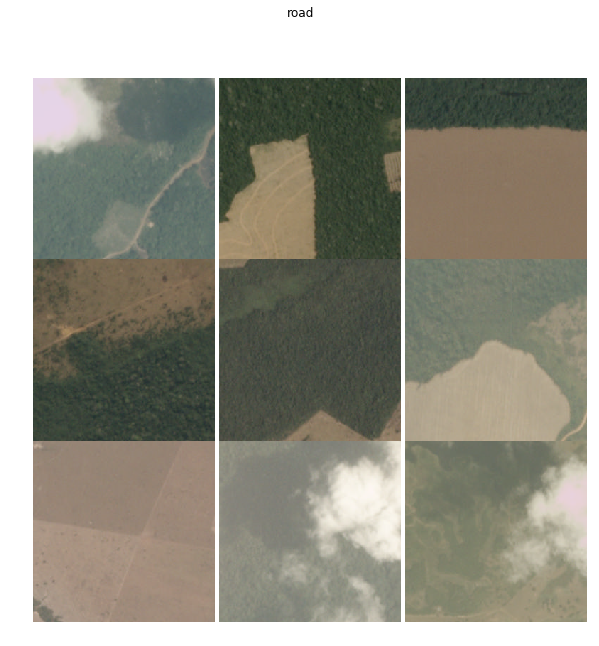

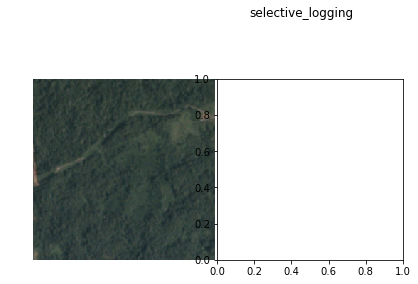

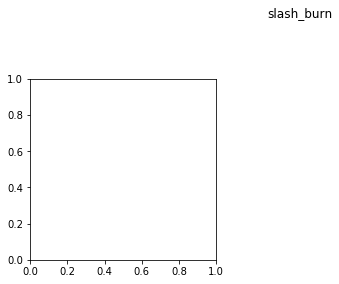

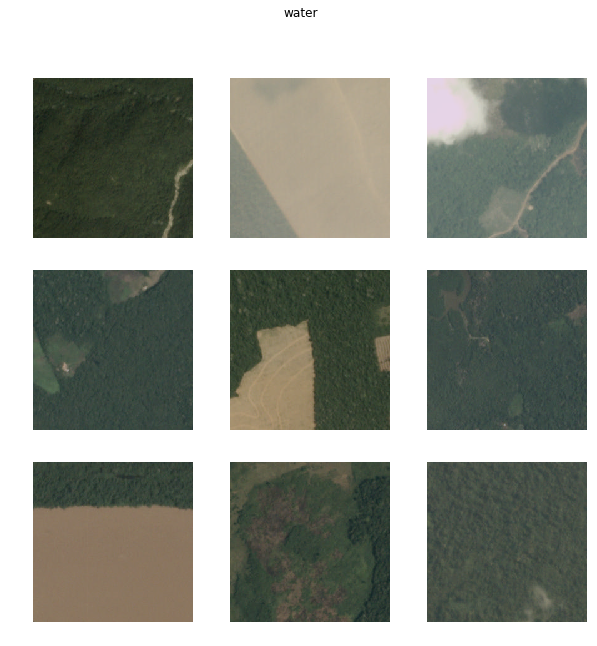

In [7]:
for l in y.columns:
    try:
        pathsx = test[test['tags'].str.contains(str(l))==True].path.tolist()[:9]
        plt.rcParams['figure.figsize'] = (10.0, 10.0)
        plt.subplots_adjust(wspace=0, hspace=0)
        fig = plt.figure()
        fig.suptitle(l)
        for x in range(9):
                plt.subplot(3, 3, x+1)
                im = Image.open(pathsx[x])
                #im = im.resize((100, 100), Image.ANTIALIAS)
                plt.imshow(im)
                plt.axis('off')
    except:
        print(l)

Visualize Feature Importance
============================

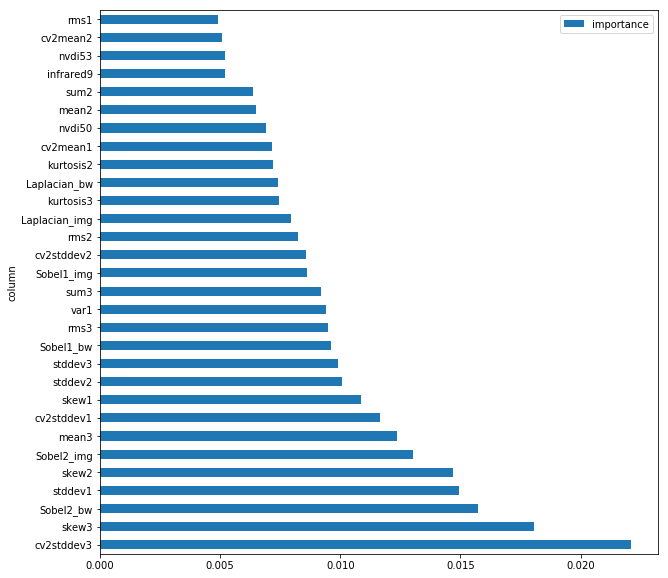

In [8]:
col = ['sum1','sum2','sum3','sum4','mean1','mean2','mean3','mean4','rms1','rms2','rms3','rms4','var1','var2','var3','var4','stddev1','stddev2','stddev3','stddev4','kurtosis1','kurtosis2','kurtosis3','skew1','skew2','skew3']
col += ['bw'+str(i) for i in range(256)]
col += ['r'+str(i) for i in range(256)]
col += ['g'+str(i) for i in range(256)]
col += ['b'+str(i) for i in range(256)]
col += ['infrared'+str(i) for i in range(256)]
col += ['nvdi'+str(i) for i in range(60)]
col += ['cv2mean1','cv2mean2','cv2mean3','cv2stddev1','cv2stddev2','cv2stddev3','Laplacian_bw','Laplacian_img','Sobel1_bw','Sobel2_bw','Sobel1_img','Sobel2_img','black_bw','white_bw']
imp = etr.feature_importances_
feat_imp = [[imp[i], col[i]] for i in range(len(imp))]
_ = pd.DataFrame(feat_imp, columns=['importance','column']).sort_values(['importance','column'], ascending=[False, False])[:30].plot(kind='barh', x='column', y='importance')